In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


from sklearn.metrics import mean_squared_error, mean_absolute_error

# Filter data to ensure non-stationarity is handled
from pmdarima import auto_arima

from helper import create_date_range


In [ ]:
df = pd.read_pickle('/Users/pranav/Git/Buy-vs-Rent/Datasets/home_value_index_co.pkl')
df

,RegionName,home_value_index
0,Denver,"[185504.77713814235, 186436.9467333193, 187388..."
1,Colorado Springs,"[160233.8979212204, 160434.15882747434, 160613..."
2,Fort Collins,"[190025.1940645129, 189747.6199006619, 190250...."
3,Boulder,"[223728.4609382274, 224677.8012129301, 225848...."
4,Greeley,"[172977.51375893544, 173245.11588292255, 17279..."
5,Pueblo,"[106730.7157606941, 106808.09563774924, 106955..."
6,Grand Junction,"[139594.79435051687, 139592.72784898907, 13836..."
7,Glenwood Springs,"[195265.96574503157, 195867.57759199225, 19659..."
8,Edwards,"[324732.96331823803, 325443.64580434107, 32660..."
9,Durango,"[262372.9925618727, 262931.2033945226, 263801...."


In [3]:
region = 'Boulder'
attribute = 'home_value_index'

values = df[df['RegionName'] == region] #Select region
values = values[attribute] #Select column
values = values.to_numpy()[0] #Convert to numpy array#Create date range
date_range = create_date_range(start='2000-01-31', end='2024-09-30', freq='M')

data = pd.DataFrame({'date': date_range, 'value': values})
data['date'] = pd.to_datetime(data['date'])
data = data.set_index(data['date']).drop('date', axis=1)
data = data.resample("MS").last()
data.head()

/Users/pranav/Git/Buy-vs-Rent/helper.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(


,value
date,
2000-01-01,223728.460938
2000-02-01,224677.801213
2000-03-01,225848.352857
2000-04-01,228292.987531
2000-05-01,230947.552744


Data is non-stationary, performing differencing.
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5247.687, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5264.199, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5280.169, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5254.758, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5333.449, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5236.756, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5270.191, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5238.100, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5236.719, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5247.779, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5636.338, Time=0.52 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5247.564, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.5

/usr/local/Caskroom/miniconda/base/envs/data_mining/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 11944.280992639038
MAE: 11472.191013811816
MAPE: 1.58%


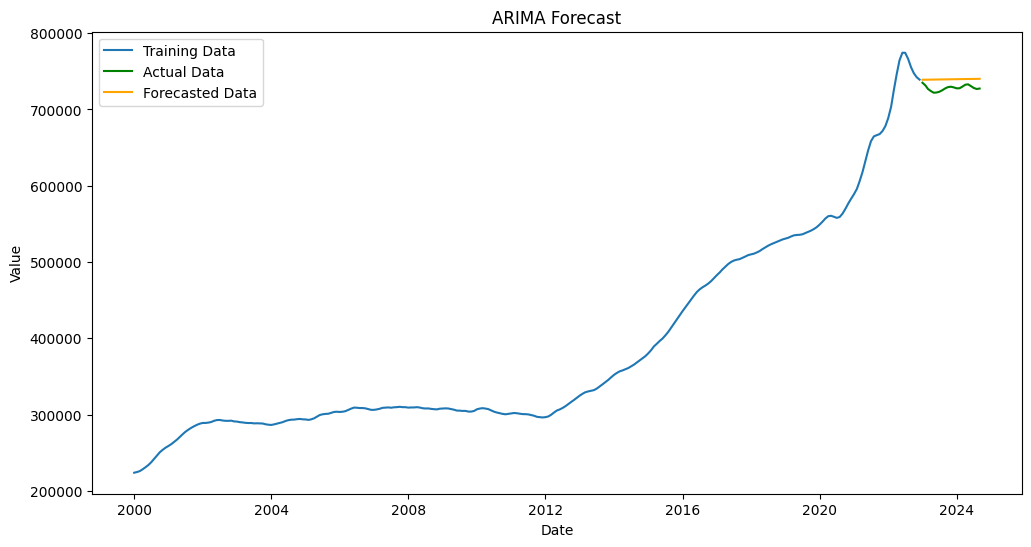

In [ ]:
# Create train-test split
train = data[data.index.year < 2023]
test = data[data.index.year >= 2023]

# Check for stationarity and differencing if needed
result = adfuller(train['value'])
if result[1] > 0.05:
    print("Data is non-stationary, performing differencing.")
    d = 1
else:
    print("Data is stationary.")
    d = 0

# Use auto_arima for optimal p, d, q parameters
stepwise_model = auto_arima(train['value'], 
                            start_p=1, start_q=1,
                            max_p=3, max_q=3, d=d,
                            seasonal=False, trace=True,
                            error_action='ignore', 
                            suppress_warnings=True, 
                            stepwise=True)

# Display the chosen order
print(f"Optimal ARIMA order: {stepwise_model.order}")

# Fit ARIMA model
model = ARIMA(train['value'], order=stepwise_model.order)
fitted_model = model.fit()

# Forecast
forecast_steps = len(test)  # Predict from 2023 onward
forecast = fitted_model.forecast(steps=forecast_steps)
forecast = pd.Series(forecast, index=test.index)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(test['value'], forecast))
mae = mean_absolute_error(test['value'], forecast)

# MAPE calculation
mape = np.mean(np.abs((test['value'] - forecast) / test['value'])) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(train['value'], label="Training Data")
plt.plot(test['value'], label="Actual Data", color='green')
plt.plot(forecast, label="Forecasted Data", color='orange')
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()
